# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Universidad Nacional de Córdoba
---

### Importación de librerías

In [197]:
import warnings
import datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBClassifier

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

### Lectura del dataset 

In [28]:
df = pd.read_parquet('sin_codificar.parquet')
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,2020-08-25,0,PL,0,202008,Hombre,5.52,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION PAMPEANA
1,000220fa96ec5af89817894033f8099c547,2020-08-25,0,PL,0,202008,Mujer,15.68,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION CUYO
2,0002be202de47dfae9cc2304d91161be595,2020-08-25,0,PL,0,202008,Mujer,5.46,Sector_Sin_Datos,28.0,95,0,Soltero,REGION PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,2020-08-25,0,PL,0,202008,Hombre,2.50,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION PAMPEANA
4,0009d010e4faf69552a814a33832b185877,2020-08-25,0,PL,0,202008,Mujer,2.10,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124309,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124310,0001f61dd2845a7e653ebfdaf22dab3b373,2021-05-14,0,PC,3,202105,Mujer,20329.24,Sector_Empleado_Comercio,48.0,98,0,Casado,REGION PATAGONIA
124311,0006c15ca823454b68c189da1344d9d7317,2021-05-14,0,PC,3,202105,Hombre,13210.67,Sector_No_Operativo,66.0,105,0,Casado,REGION NORDESTE
124312,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,121.73,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE


Ordenamos nuestro conjunto de datos en función a la variable anio_mes_cupon.

In [29]:
df = df[~df.duplicated()]
df.duplicated().value_counts()

False    54010
dtype: int64

In [30]:
df = df.sort_values(by = ['anio_mes_cupon'], ascending = True)
df

,dni_titular_movimiento,fecha_cupon_movimiento,moneda_movimiento,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,anio_mes_cupon,sexo_descripcion,monto_ajustado,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
85858,0001a3ea0e2a1394ddba4679b09ca7a1561,2020-07-31,0,PL,3,202007,Hombre,181.16,Sector_Sin_Datos,80.0,19,5,Soltero,REGION NOROESTE
74714,00037938025ac60849e60d3f3fa42cdc833,2020-07-28,3,PL,3,202007,Mujer,618.52,Sector_Educativo,39.0,124,1,Soltero,REGION PAMPEANA
74715,00037938025ac60849e60d3f3fa42cdc833,2020-07-26,3,PL,3,202007,Mujer,1350.43,Sector_Educativo,39.0,124,1,Soltero,REGION PAMPEANA
101268,0003a7e1566088a9a9b1fc374c49ef4e389,2020-07-29,0,VI,22,202007,Hombre,1319.95,Sector_Sin_Datos,50.0,45,9,Casado,REGION PAMPEANA
101269,0003a7e1566088a9a9b1fc374c49ef4e389,2020-07-25,0,VI,22,202007,Hombre,4619.57,Sector_Sin_Datos,50.0,45,9,Casado,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72398,00068ec69c7a0fef0047dece18e1d905386,2021-05-07,0,ZE,3,202105,Mujer,1968.66,Sector_Sin_Datos,58.0,78,0,Casado,REGION PAMPEANA
72399,0000e7b72ab4fe0dbdcba6e189bc4bd3190,2021-05-11,0,ZE,3,202105,Mujer,2462.32,Sector_Empleado_Comercio,57.0,121,0,Casado,REGION NOROESTE
72389,0003dd9ab940e4a4fb953141abbe57aa237,2021-05-10,0,ZE,3,202105,Hombre,2814.60,Sector_Sin_Datos,41.0,3,0,Soltero,REGION NORDESTE
124313,0000ab27a0ed815f947df8bcb834ff97975,2021-05-03,0,PC,3,202105,Hombre,12284.16,Sector_Empleado_Comercio,74.0,140,0,Soltero,REGION NOROESTE


In [31]:
df['monto_ajustado'].describe().round(2)

count    54010.00
mean      1626.05
std       4172.44
min     -35117.69
25%         88.42
50%        271.75
75%       1337.98
max      63616.14
Name: monto_ajustado, dtype: float64

Distribución de nuestro target respecto a nuestros features

### ScatterPlot de Features y Target

In [32]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [33]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['fecha_cupon_movimiento', 'moneda_movimiento',
       'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento',
       'anio_mes_cupon', 'sexo_descripcion', 'cargo_sector_desc_hist',
       'edad_cliente', 'antig_cliente', 'comercio_cat',
       'estado_civil_cat', 'region'], dtype=object)

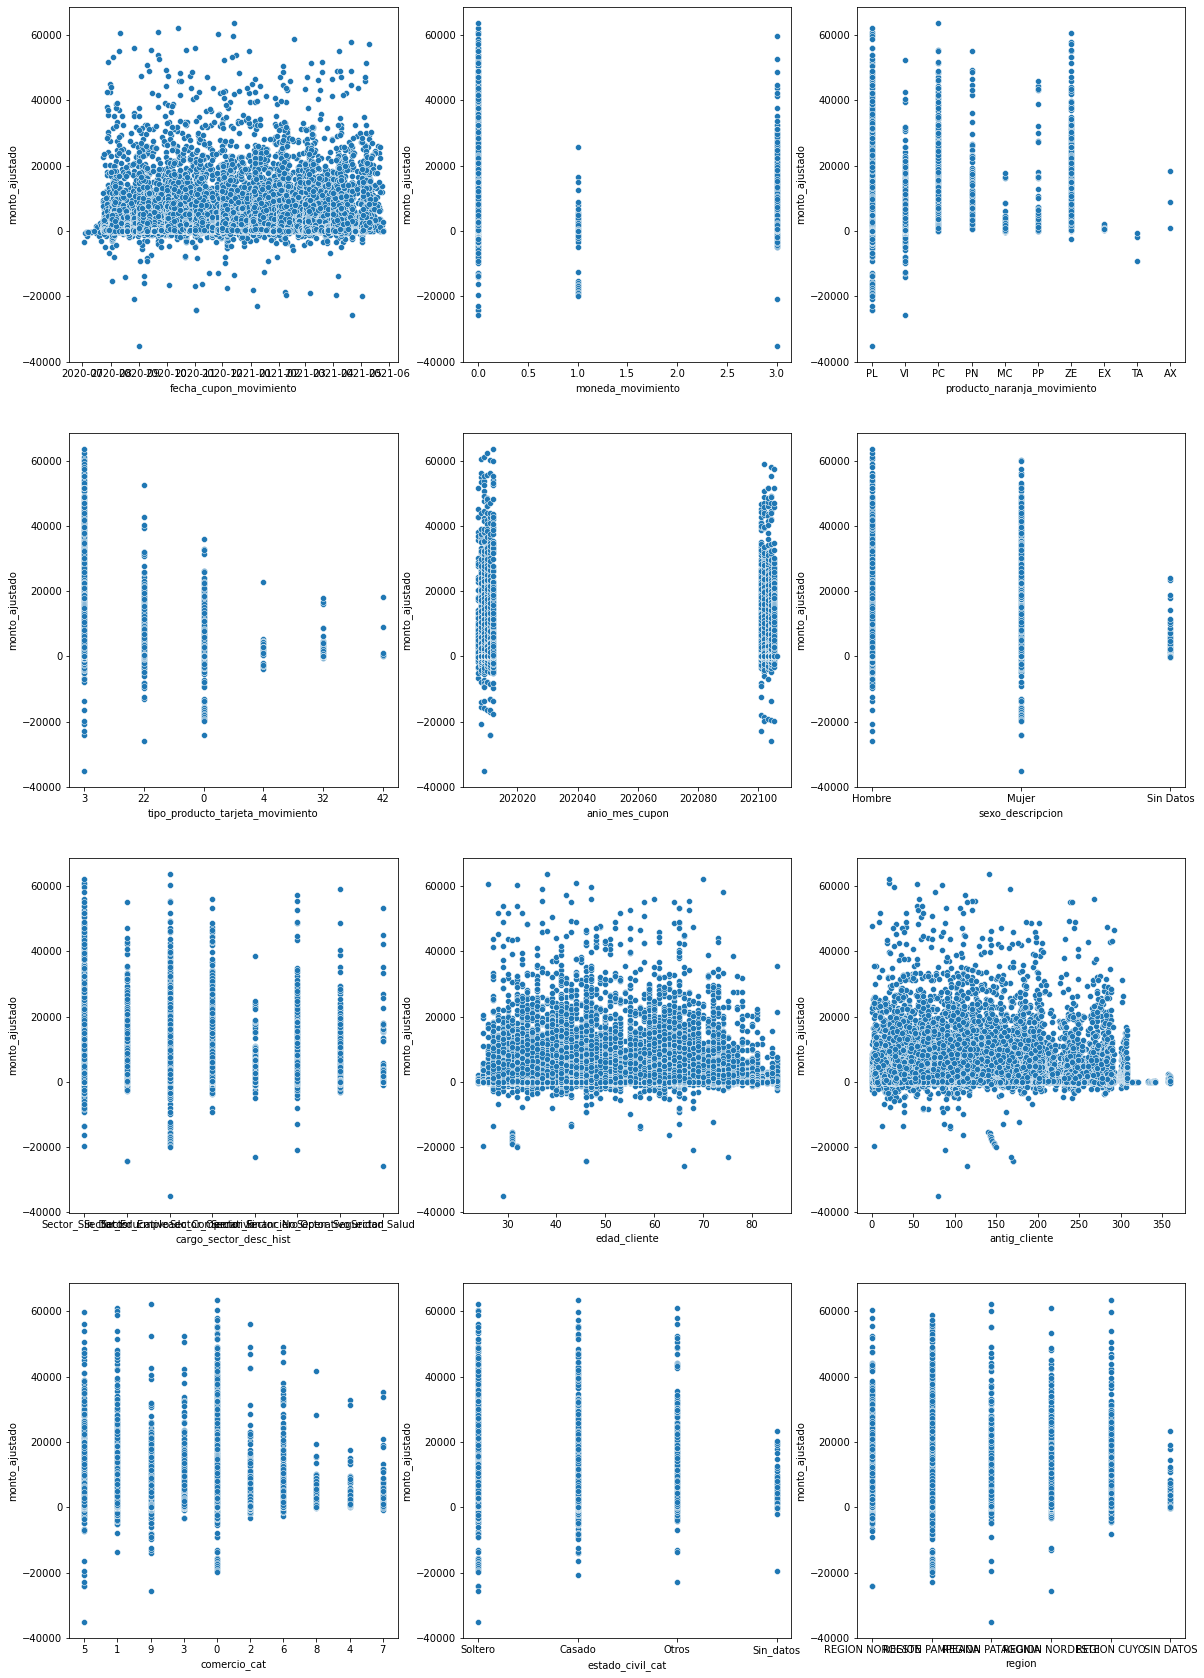

In [34]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

#axs[n_rows-1,n_cols-1].axis('off')
plt.show()

Analisis de distribucion de monto_ajustado con respecto a los features numericos

- **fecha_cupon_movimiento**: No hay una relacion visible. Los puntos estan distribuidos mayoritariamente en el rango entre 0 y 20000 para casi todos los meses presentes con excepcion del primer mes donde la cantidad de casos baja con respecto al resto de los meses.
- **edad_cliente**: Similar a fecha, la mayor parte de los montos se concentra entre 0 y 20000. Algo a destacar es que a medida que la edad supera los 60 años, la cantidad de transacciones baja. El grueso de transacciones estan concentradas en edades menores a 70
- **antiguedad_cliente**: A partir de la antiguedad 200, se puede observar que la cantidad de transacciones baja, lo cual podria explicarse en base a que hay menos clientes con antiguedad tan alta. Sin embargo, se puede llegar a ver una aplanacion mas paulatina de los casos que en el caso de la edad. Despues de cierta antiguedad la cantidad de transacciones baja pero se mantiene en una meseta, en cambio en el caso de la edad la baja es mas abrupta.

El scatterplot de features categoricos nos brinda unicamente informacion sobre la concentracion de casos en cada categoria, pero no podriamos con eso solo proyectar el comportamiento de las regresiones para la prediccion de los montos. 

### Seleccion de columnas

Realizamos una separación de las distintas features segun el preproceso necesario. 

- **Variable ordinal**: DNI identifica univocamente al cliente pero al ser ordinal debe excluirse de los modelos
- **target de regresion**: monto_ajustado
- **target de clasificacion**: fg_aumentado
- **features numericas**: Se les aplicara un normalizador o estandarizador según sea necesario
- **features categoricas de la transaccion**: Al momento de agrupar por mes, se sumarizan para convertirlas a numericas
- **features categoricas del cliente**: Se mantienen como categoricas para retener la información del cliente

In [39]:
ordinal_ft = 'dni_titular_movimiento'
target = 'monto_ajustado'
target_c = 'fg_aumentado'

# Features numericas
num_features = ['anio_mes_cupon', 'edad_cliente', 'antig_cliente', 'fecha_cupon_movimiento']

# Features categoricas de la transaccion
trans_ft = ['producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento', 'moneda_movimiento', 'comercio_cat']

# Features categoricas del cliente
client_ft = ['sexo_descripcion', 'cargo_sector_desc_hist', 'estado_civil_cat', 'region']

In [40]:
# Ordenamos por fecha
df = df.sort_values(by = ['fecha_cupon_movimiento'], ascending = True)
# Transformacion de fecha a numerica
df['fecha_cupon_movimiento'] = df['fecha_cupon_movimiento'].values.astype(float)/10**11
# Transformacion de tipo de moneda a string
df['moneda_movimiento'] = df['moneda_movimiento'].astype(str)


# Codificación
cat_transformer = OneHotEncoder(handle_unknown='ignore')

encoder = ColumnTransformer(
    transformers=[
        ('dni', 'drop', [ordinal_ft]),
        ('num', 'passthrough', num_features),
        ('trans', cat_transformer, trans_ft),
        ('client', cat_transformer, client_ft),
        ('target', 'passthrough', [target])])
df_enc = encoder.fit_transform(df)
cols = encoder.get_feature_names()

# Agregar feature ordinal al principio del dataframe

dff_enc = pd.DataFrame.sparse.from_spmatrix(df_enc, columns=[cols]).sparse.to_dense()
cols_o = np.hstack([[ordinal_ft],cols])
df_stack = np.hstack([df[[ordinal_ft]],dff_enc])
df_encode = pd.DataFrame(df_stack , columns=cols_o)

### Agrupación por Mes

Definimos distintas funciones de agregacion segun el tipo de feature definido anteriormente. Las features del cliente se mantienen en todo el dataset para cada cliente, por lo que aplicarles 'max' no significaria una perdida de informacion. Las columnas relacionadas a la transaccion se suman para contabilizar las transacciones para esa categoria en el mes que se va a agrupar.

In [41]:
# Funciones de agregacion para cada columna
aggr = {} 
aggr.update(dict.fromkeys([x for x in cols if 'client' in x], 'max'))
aggr.update(dict.fromkeys([x for x in cols if 'trans' in x], 'sum'))
aggr.update({target:'sum'})

# Convertimos las columnas categoricas de la transaccion a numericas para poder sumarizarlas
df_encode[num_features + [x for x in cols if 'trans' in x]] = \
df_encode[num_features + [x for x in cols if 'trans' in x]].apply(pd.to_numeric)

# Agrupamiento
group = ['dni_titular_movimiento', 'anio_mes_cupon']

df_mes = df_encode.groupby(group).agg(aggr).reset_index() # edad y antiguedad

In [42]:
df_mes.describe()

,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,client__x1_Sector_No_Operativo,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
count,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,...,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000,7443.000000
mean,202052.953245,49.149536,107.739755,0.460836,0.533118,0.006046,0.058444,0.193202,0.011017,0.084106,...,1.505441,0.264947,0.154776,0.011286,0.759909,0.110574,0.022437,0.047293,1.127099,11799.386270
std,46.437423,14.954749,76.457279,0.498497,0.498935,0.077526,0.234597,0.394836,0.104389,0.277565,...,2.712571,0.909321,0.913168,0.166800,1.622287,0.710803,0.303002,0.442828,2.920973,14911.904828
min,202007.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14160.390000
25%,202010.000000,36.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,958.790000
50%,202012.000000,47.000000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6339.410000
75%,202103.000000,61.000000,156.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,17236.215000
max,202106.000000,85.000000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.000000,18.000000,17.000000,7.000000,50.000000,27.000000,14.000000,12.000000,60.000000,134045.420000


## TENEMOS DNIs CON 1 SOLO UN MES DE MOVIMIENTO. VER LUEGO

In [93]:
df_copy = df_mes.copy()
cols = df_copy.columns.values
cols_trans = [x for x in cols if 'trans' in x]

df_copy[df_copy['dni_titular_movimiento']=='000c428be17ead5d2e0bea5db86a67f7203'][cols_trans]=0
df_copy[df_copy['dni_titular_movimiento']=='000c428be17ead5d2e0bea5db86a67f7203']

,dni_titular_movimiento,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
5962,000c428be17ead5d2e0bea5db86a67f7203,202104.0,41.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16782.35


In [94]:
array_mes = df_mes.anio_mes_cupon.unique()
array_dni = df_mes.dni_titular_movimiento.unique()

In [95]:
dic = {'dni_titular_movimiento': [],
       'anio_mes_cupon': []}
for dni in array_dni:
    for mes in array_mes:
        dic['dni_titular_movimiento'].append(dni)
        dic['anio_mes_cupon'].append(mes)
df_dni_mes = pd.DataFrame(dic)
df_dni_mes.head()

,dni_titular_movimiento,anio_mes_cupon
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0


In [100]:
prueba = pd.concat([df_copy,df_dni_mes])
prueba.shape

(17343, 55)

In [101]:
prueba[prueba['dni_titular_movimiento']=='000c428be17ead5d2e0bea5db86a67f7203']

,dni_titular_movimiento,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
5962,000c428be17ead5d2e0bea5db86a67f7203,202104.0,41.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16782.35
7860,000c428be17ead5d2e0bea5db86a67f7203,202008.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7861,000c428be17ead5d2e0bea5db86a67f7203,202009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7862,000c428be17ead5d2e0bea5db86a67f7203,202010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7863,000c428be17ead5d2e0bea5db86a67f7203,202011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7864,000c428be17ead5d2e0bea5db86a67f7203,202012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7865,000c428be17ead5d2e0bea5db86a67f7203,202101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7866,000c428be17ead5d2e0bea5db86a67f7203,202102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7867,000c428be17ead5d2e0bea5db86a67f7203,202103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7868,000c428be17ead5d2e0bea5db86a67f7203,202104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
pd.MultiIndex.from_product([df_copy.index.unique()],
                           names=['dni','mes']).reset_index(level=1)

NotImplementedError: isna is not defined for MultiIndex

In [83]:
df_copy.index.unique()

MultiIndex([('000000b5aea2c9ea7cc155f6ebcef97f826', 202008.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202009.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202010.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202011.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202012.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202101.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202102.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202103.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202104.0),
            ('000000b5aea2c9ea7cc155f6ebcef97f826', 202105.0),
            ...
            ('000f0b73ebfa002a79a0642b82e87919904', 202008.0),
            ('000f0b73ebfa002a79a0642b82e87919904', 202009.0),
            ('000f0b73ebfa002a79a0642b82e87919904', 202010.0),
            ('000f0b73ebfa002a79a0642b82e87919904', 202011.0),
            ('000f0b73ebfa002a79a0642b82e87919904', 202012.0),
            ('000f0b73ebfa002a79a0642b8

In [46]:
array_mes

array([202008., 202009., 202010., 202011., 202012., 202101., 202102.,
       202103., 202104., 202105., 202007., 202106.])

In [38]:
prueba = df_copy.set_index('anio_mes_cupon',append=True)

In [52]:
import RandomOverSampler

ModuleNotFoundError: No module named 'RandomOverSampler'

# Modelos de Regresión - Predicción de consumo

## Linear SVR - Default

LinerSVR es un modelo lineal. Teniendo en cuenta las visualizaciones al principio del practico donde observamos que las features numericas no se relacionan de forma lineal con el objetivo, no podriamos esperar mucho de este modelo o cualquier modelo lineal dado el caso.

Elegimos MinMaxScaler para escalar las features numericas porque conserva el signo, y tenemos transacciones en negativo para la variable objetivo.

Usamos _SelectFromModel()_ para reducir el numero de features del dataset, y de esa manera intentar mejorar las predicciones con un costo de computo menor al que si usaramos todas las features. Para seleccionar las columnas usamos _RandomForestRegressor_

In [481]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = LinearSVR(random_state=0)

In [482]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [483]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=0, shuffle=False)

Elegimos una relacion entre train y test de un 35% para test. Esto lo hicimos en base a que en pruebas anteriores tuvimos casos donde el MSE para el conjunto de validacion era menor que en de train. Investigando sobre esto, dimos con que este problema se denomina under-fitting. Al tratarse de un modelo lineal tratando de predecir datos no lineales, este problema es esperable. Modificamos la cantidad de datos en train y test para prevenir la sobre simplificacion del modelo sobre los datos  e intentar reducir este problema. 

#### Preproceso y ajuste

In [484]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [485]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
svr = model

In [487]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [488]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 298679823.584, Valid error 307770657.238


In [489]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 17282.356, Valid error RMSE 17543.394


In [490]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 10542.977, Valid error MAE 10346.221


Visualizamos nuestra variable target (real y predicción)

In [52]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2606.00
mean,11570.39
std,15249.64
min,-14160.00
25%,785.50
50%,5932.50
75%,16798.50
max,134045.00


In [53]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2606.00
mean,3112.67
std,673.63
min,1419.99
25%,2614.46
50%,3105.96
75%,3604.59
max,4994.45


## Linear SVR - Grid Search

In [125]:
param_grid = {
    'regressor__epsilon': [0.1, 0.01, 0.0001,0.001],
    'regressor__tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'regressor__C': [1, 2, 0.01, 0.001],
    'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [55]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = LinearSVR(random_state=0)

In [56]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [57]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [59]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=40)

model.fit(X_train, y_train)
svr_cv = model

In [60]:
model.best_params_

{'regressor__tol': 0.001,
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__epsilon': 0.0001,
 'regressor__C': 0.01}

In [61]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [62]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 116561350.044, Valid error 135760481.582


In [63]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 10796.358, Valid error RMSE 11651.63


In [64]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 7171.465, Valid error MAE 7466.199


Visualizamos nuestra variable target (real y predicción)

In [65]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [66]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11414.73
std,8218.79
min,-708.86
25%,5262.31
50%,9382.17
75%,15741.21
max,64915.29


## SGDRegressor - Default

In [67]:
# Preproceso 1 para SGDRegressor - Default, RMSE 3395.724
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [68]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [69]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [70]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [71]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
sgd = model

In [72]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [73]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 110013126.226, Valid error 126905950.859


In [74]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 10488.714, Valid error RMSE 11265.254


In [75]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 6620.926, Valid error MAE 6866.711


Visualizamos nuestra variable target (real y predicción)

In [76]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [77]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11579.65
std,10714.44
min,-114.09
25%,3690.73
50%,8696.98
75%,16416.31
max,90026.32


## SGDRegressor- Grid Search

In [78]:
param_grid = {
    'regressor__loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'regressor__penalty': ['l2','l1'],
    'regressor__alpha': [0.01, 0.1, 1],
    'regressor__epsilon': [0.1, 0.01],
    'regressor__tol': [1e-3, 1e-4],
    'regressor__learning_rate': ['optimal', 'adaptive', 'invscaling', 'constant']
    #'max_iter': [1000, 2000, 5000]
}

In [79]:
# Preproceso 1 para SGDRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = SGDRegressor(random_state=0, shuffle=False)

In [80]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [81]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [82]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [83]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, n_iter=20)

model.fit(X_train, y_train)
sgd_cv = model

In [60]:
model.best_params_

{'regressor__tol': 0.001,
 'regressor__loss': 'squared_epsilon_insensitive',
 'regressor__epsilon': 0.0001,
 'regressor__C': 0.01}

In [84]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [85]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 225534060.326, Valid error 240605109.817


In [86]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 15017.791, Valid error RMSE 15511.451


In [87]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 9260.566, Valid error MAE 9204.421


Visualizamos nuestra variable target (real y predicción)

In [88]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [89]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,6212.90
std,1693.33
min,3707.48
25%,4881.20
50%,5698.22
75%,7451.70
max,12826.56


## KNeighborsRegressor - Default

In [90]:
# Preproceso 1 para SGDRegressor - GridSearch, RMSE 3778.109
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [91]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [92]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

In [93]:
X_train.shape

(5210, 53)

In [94]:
X_val.shape

(2233, 53)

#### Preproceso y ajuste

In [95]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [96]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
knn = model

In [97]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [98]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 73063078.761, Valid error 174264083.239


In [99]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 8547.694, Valid error RMSE 13200.912


In [100]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 5119.237, Valid error MAE 7767.42


Visualizamos nuestra variable target (real y predicción)

In [101]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [102]:
pd.DataFrame(y_valid_pred.astype(int), columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,9940.77
std,9474.78
min,-608.00
25%,1690.00
50%,7862.00
75%,15513.00
max,63892.00


## KNeighborsRegressor - Grid Search

In [103]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = LinearSVR(random_state=0)
model_ = KNeighborsRegressor()

In [104]:
param_grid = {
    'regressor__n_neighbors': [20,25,30,35],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto','ball_tree','kd_tree','brute'],
    'regressor__p': [1,2]
}

Elegimos valores altos de K, porque?

In [105]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [106]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [107]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [108]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5)

model.fit(X_train, y_train)
knn_cv = model

In [109]:
model.best_params_

{'regressor__algorithm': 'ball_tree',
 'regressor__n_neighbors': 35,
 'regressor__p': 1,
 'regressor__weights': 'distance'}

In [110]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [111]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 5230396.772, Valid error 171988275.278


In [112]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 2287.006, Valid error RMSE 13114.43


In [113]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 592.43, Valid error MAE 7412.593


Visualizamos nuestra variable target (real y predicción)

In [114]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [115]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,8999.17
std,8134.47
min,-3445.56
25%,2253.81
50%,6917.40
75%,14195.31
max,51630.43


## GaussianProcessRegressor - Default

In [500]:
# Preproceso 1 para GaussianProcessRegressor - Default
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [501]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [502]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [503]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [504]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
gpr = model

In [505]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [506]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 37.903, Valid error 7576475654.945


In [507]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 6.157, Valid error RMSE 87042.953


In [508]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 0.361, Valid error MAE 27292.733


Visualizamos nuestra variable target (real y predicción)

In [135]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [136]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,778.71
std,1952.61
min,-6809.03
25%,5.89
50%,143.35
75%,663.18
max,30327.68


## GaussianProcessRegressor - Grid Search 

In [143]:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")
ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)
ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf, ker_rq, ker_expsine]

param_grid = {"regressor__kernel": kernel_list,
              "regressor__alpha": [0.1]}

In [144]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = StandardScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = GaussianProcessRegressor(random_state=0) # Kernel?

In [145]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [146]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [147]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [148]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=2)

model.fit(X_train, y_train)
gpr_cv = model

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=  13.3s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=  14.1s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=  13.4s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=  13.3s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RBF(length_scale=1); total time=  13.9s
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 2.4min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 2.3min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=1); total time= 2.7min
[CV] END regressor__alpha=0.1, regressor__kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale

In [149]:
model.best_params_

{'regressor__alpha': 0.1,
 'regressor__kernel': 1**2 * RationalQuadratic(alpha=0.1, length_scale=1)}

In [150]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [151]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 1365929.338, Valid error 179531721.684


In [152]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 1168.73, Valid error RMSE 13398.945


In [153]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 772.509, Valid error MAE 9282.836


Visualizamos nuestra variable target (real y predicción)

In [154]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [155]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,12080.70
std,5466.87
min,189.17
25%,8057.07
50%,11342.96
75%,15707.30
max,32269.24


## XGBRegressor - Default

In [470]:
# Preproceso 1 para XGBRegressor - Default
df = df_mes.copy()
scaler = MinMaxScaler()
#ft_selector = RandomForestRegressor(random_state=0)
model_ = XGBRegressor(random_state=0, verbosity=1)

In [471]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [472]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#### Preproceso y ajuste

In [473]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [474]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)
xgb = model

In [476]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [477]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 23700398.83, Valid error 95382716.756


In [478]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 4868.306, Valid error RMSE 9766.408


In [479]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 3030.424, Valid error MAE 6172.086


Visualizamos nuestra variable target (real y predicción)

In [442]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,1489.00
mean,11569.49
std,14077.22
min,-10944.00
25%,990.00
50%,6509.00
75%,17515.00
max,134045.00


In [443]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,1489.00
mean,11789.75
std,12083.25
min,-4844.17
25%,2412.47
50%,8941.93
75%,17134.61
max,109382.84


## XGBRegressor - Grid Search

In [458]:
# Preproceso 1 para KNeighborsRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
model_ = XGBRegressor(random_state=0)#, booster='gbtree')

La combinacion de hiperparametros es mas densa en este modelo porque fue el que mejor resultados dio en cuanto a RMSE

In [459]:
#param_grid = {'regressor__max_depth': [None]}
#              'regressor__eta': [0.15, 0.1, 0.08],
           #   'regressor__subsample': [None],
           #   'regressor__colsample_bytree': [None]}
param_grid = {}    

In [460]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [461]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [465]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client__' not in g]
cat_features = [g for g in X.columns if 'client__' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [452]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1)

model.fit(X_train, y_train)
xgb_cv = model

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [453]:
model.best_params_

{'regressor__max_depth': None}

In [454]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [455]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 20254433.498, Valid error 140410168.283


In [456]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 4500.493, Valid error RMSE 11849.48


In [457]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 2834.32, Valid error MAE 7333.285


Visualizamos nuestra variable target (real y predicción)

In [190]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [191]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,11726.95
std,10296.11
min,-1469.61
25%,4047.28
50%,8805.49
75%,16367.67
max,83913.07


## VotingRegressor

In [290]:
# Preproceso 1 para GaussianProcessRegressor - GridSearch
df = df_mes.copy()
scaler = MinMaxScaler()
ft_selector = RandomForestRegressor(random_state=0)
model_ = VotingRegressor([#('svr', svr['regressor']),
                      #    ('sgd', sgd['regressor']),
                          ('knn', knn['regressor']),
                          ('gpr', gpr['regressor']),
                          ('xgb', xgb['regressor']),
                          ('knn_cv', knn_cv.best_estimator_['regressor']),
                          ('gpr_cv', gpr_cv.best_estimator_['regressor']),
                          ('xgb_cv', xgb_cv.best_estimator_['regressor'])], verbose=True)

In [291]:
# Features and target
X = df.drop([ordinal_ft, target], axis=1)
y = df[target]

In [292]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [293]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [294]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('regressor', model_)
])

model.fit(X_train, y_train)

[Voting] ...................... (1 of 6) Processing knn, total=   0.0s
[Voting] ...................... (2 of 6) Processing gpr, total=  20.5s
[Voting] ...................... (3 of 6) Processing xgb, total=   1.9s
[Voting] ................... (4 of 6) Processing knn_cv, total=   0.0s
[Voting] ................... (5 of 6) Processing gpr_cv, total=  45.4s
[Voting] ................... (6 of 6) Processing xgb_cv, total=   0.1s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['anio_mes_cupon',
                                                   'trans__x0_AX',
                                                   'trans__x0_EX',
                                                   'trans__x0_MC',
                                                   'trans__x0_PC',
                                                   'trans__x0_PL',
                                                   'trans__x0_PN',
                                                   'trans__x0_PP',
                                                   'trans__x0_TA',
                                                   'trans__x0_VI',
                                                   'trans__x0_ZE',
                                                   'trans__x1_0',
                                                   'trans__x1_22',
                      

#### Evaluacion de predicciones

In [295]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

In [296]:
# evaluate MSE:
train_error = mean_squared_error(y_train, y_train_pred)
val_error = mean_squared_error(y_val, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')  

Train error 13287362.944, Valid error 189100654.35


In [297]:
# evaluate RMSE:
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_error = np.sqrt(mean_squared_error(y_val, y_valid_pred))
print(f'Train error RMSE {train_error.round(3)}, Valid error RMSE {val_error.round(3)}')  

Train error RMSE 3645.184, Valid error RMSE 13751.387


In [298]:
# evaluate MAE:
train_error = mean_absolute_error(y_train, y_train_pred)
val_error = mean_absolute_error(y_val, y_valid_pred)
print(f'Train error MAE {train_error.round(3)}, Valid error MAE {val_error.round(3)}')  

Train error MAE 2346.096, Valid error MAE 8198.295


Visualizamos nuestra variable target (real y predicción)

In [299]:
pd.DataFrame(y_val.values.astype(int), columns=['val_real']).describe().round(2)

,val_real
count,2233.00
mean,11556.58
std,15358.95
min,-14160.00
25%,860.00
50%,5740.00
75%,16782.00
max,134045.00


In [300]:
pd.DataFrame(y_valid_pred, columns=['val_pred']).describe().round(2)

,val_pred
count,2233.00
mean,7857.30
std,4512.05
min,515.39
25%,4526.68
50%,6985.40
75%,10392.71
max,34245.38


# Modelos de Clasificacion - Predecir aumento de gasto mensual

## Preprocesamiento

### 1.2 Creación de variable categórica 

Creamos una columna que indica si un cliente ha aumentado su consumo personal mes a mes. El mes inicial para cada cliente se inicializa en 0.

Cabe destacar que a la hora de agrupar los movimientos en cada mes, se considera la fecha de cierre de la tarjeta, por lo cual cada mes comprende desde el dia 25 del mes anterior hasta el dia 24 del corriente, inclusive. 

In [142]:
df_mes

,dni_titular_movimiento,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_1,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,000f0b73ebfa002a79a0642b82e87919904,202101.0,64.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11616.45
7439,000f0b73ebfa002a79a0642b82e87919904,202102.0,64.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12566.68
7440,000f0b73ebfa002a79a0642b82e87919904,202103.0,64.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2663.08
7441,000f0b73ebfa002a79a0642b82e87919904,202104.0,64.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4685.64


In [143]:
# Agregación de la nueva columna seteada en 0.
# En la iteración, se le cambia el valor a 1 en caso de que cumpla con las condiciones preestablecidas.

df_mes['fg_aumentado'] = 0
for i in range(1,len(df_mes)):
    if (df_mes.iloc[i]['dni_titular_movimiento'] == df_mes.iloc[i-1]['dni_titular_movimiento']) \
        & (df_mes.iloc[i]['anio_mes_cupon'] > df_mes.iloc[i-1]['anio_mes_cupon']):
            var_mes = df_mes.iloc[i]['monto_ajustado'] - df_mes.iloc[i-1]['monto_ajustado']
            if (var_mes > (abs(df_mes.iloc[i-1]['monto_ajustado'])*0.1)):
                df_mes.loc[i,'fg_aumentado'] = 1

In [144]:
df_mes.head(20)

,dni_titular_movimiento,anio_mes_cupon,edad_cliente,antig_cliente,client__x0_Hombre,client__x0_Mujer,client__x0_Sin Datos,client__x1_Sector_Educativo,client__x1_Sector_Empleado_Comercio,client__x1_Sector_Financiero,...,trans__x3_2,trans__x3_3,trans__x3_4,trans__x3_5,trans__x3_6,trans__x3_7,trans__x3_8,trans__x3_9,monto_ajustado,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008.0,46.0,225.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.72,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009.0,47.0,226.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.61,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010.0,47.0,227.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.46,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011.0,47.0,228.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.34,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012.0,47.0,229.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.21,0
5,000000b5aea2c9ea7cc155f6ebcef97f826,202101.0,47.0,230.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.08,0
6,000000b5aea2c9ea7cc155f6ebcef97f826,202102.0,47.0,231.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.97,0
7,000000b5aea2c9ea7cc155f6ebcef97f826,202103.0,47.0,232.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.83,0
8,000000b5aea2c9ea7cc155f6ebcef97f826,202104.0,47.0,233.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.72,0
9,000000b5aea2c9ea7cc155f6ebcef97f826,202105.0,47.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.64,0


In [145]:
df = df_mes.copy() # Usamos siempre df_mes para clasificar

## RandomForestClassifier - Default

In [146]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
ft_selector = RandomForestClassifier(random_state=0)
model_ = RandomForestClassifier(random_state= 0, max_depth=20, min_samples_split=20)

In [147]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [148]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [149]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [150]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
rfc = model

In [151]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

In [152]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                    ['anio_mes_cupon', 'trans__x0_AX',
                                     'trans__x0_EX', 'trans__x0_MC',
                                     'trans__x0_PC', 'trans__x0_PL',
                                     'trans__x0_PN', 'trans__x0_PP',
                                     'trans__x0_TA', 'trans__x0_VI',
                                     'trans__x0_ZE', 'trans__x1_0', 'trans__x1_22',
                                     'trans__x1_3', 'trans__x1_32', 'trans__x1_4',
                                     'trans__x1_42', 'trans__x2_0', 'trans__x2_1',
                                     'trans__x2_3'...
                                     'client__x1_Sector_Operativo',
                                     'client__x1_Sector_Salud',
                                     'client__x1_Sector_Seguridad',
                                     'client_

#### Evaluacion de predicciones

In [153]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3402
           1       0.89      0.78      0.83      1808

    accuracy                           0.89      5210
   macro avg       0.89      0.87      0.88      5210
weighted avg       0.89      0.89      0.89      5210



In [154]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1433
           1       0.64      0.56      0.60       800

    accuracy                           0.73      2233
   macro avg       0.70      0.69      0.70      2233
weighted avg       0.72      0.73      0.72      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

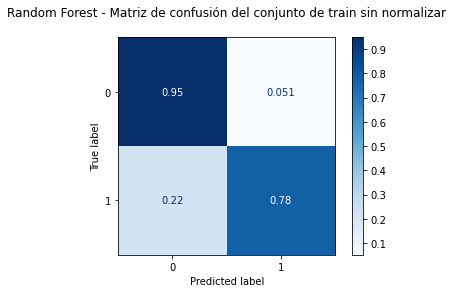

In [155]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

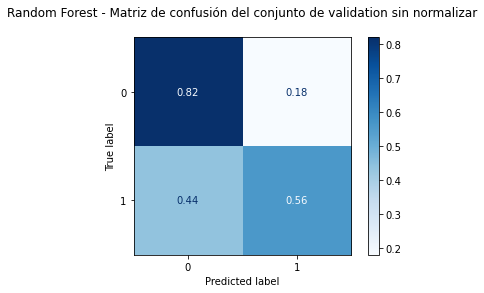

In [156]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## RandomForestClassifier - Grid Search

In [157]:
# Preproceso 1 para SGDRegressor - Default
scaler = MinMaxScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = RandomForestClassifier(random_state= 0)

In [158]:
param_grid = {'cla__n_estimators' : [75, 100],
                'cla__criterion':['gini', 'entropy'],
                'cla__max_depth': [20, 25],
                'cla__min_samples_split': [20, 25],
                'cla__min_samples_leaf':[5, 6, 8],
                'cla__max_features':[0.5, 0.7, 0.8]}

In [159]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [160]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [161]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [162]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = RandomizedSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
rfc_cv = model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [163]:
model.best_params_

{'cla__n_estimators': 100,
 'cla__min_samples_split': 20,
 'cla__min_samples_leaf': 6,
 'cla__max_features': 0.5,
 'cla__max_depth': 25,
 'cla__criterion': 'entropy'}

In [164]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [165]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3402
           1       0.89      0.78      0.83      1808

    accuracy                           0.89      5210
   macro avg       0.89      0.86      0.87      5210
weighted avg       0.89      0.89      0.89      5210



In [166]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1433
           1       0.64      0.56      0.60       800

    accuracy                           0.73      2233
   macro avg       0.70      0.69      0.70      2233
weighted avg       0.72      0.73      0.72      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

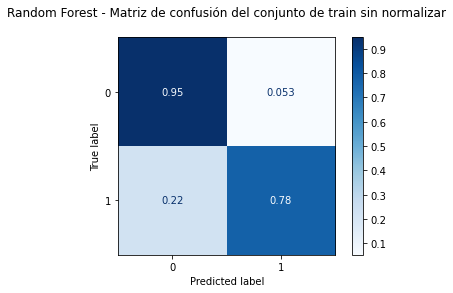

In [167]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

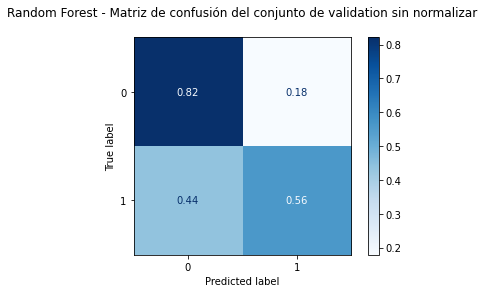

In [168]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Default

In [169]:
# Preproceso 1 para XGBClassifier - Default
scaler = MaxAbsScaler()
ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0)

In [170]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [171]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [172]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [173]:
# Fit
model = Pipeline([
  ('preprocessor', preprocessor),
  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model.fit(X_train, y_train)
xgbc = model

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Yasha\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:09:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [174]:
# Predict
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [175]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3402
           1       0.89      0.78      0.83      1808

    accuracy                           0.89      5210
   macro avg       0.89      0.86      0.87      5210
weighted avg       0.89      0.89      0.89      5210



In [176]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1433
           1       0.60      0.54      0.57       800

    accuracy                           0.71      2233
   macro avg       0.68      0.67      0.67      2233
weighted avg       0.70      0.71      0.70      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

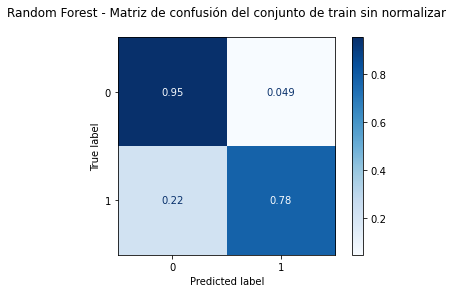

In [177]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

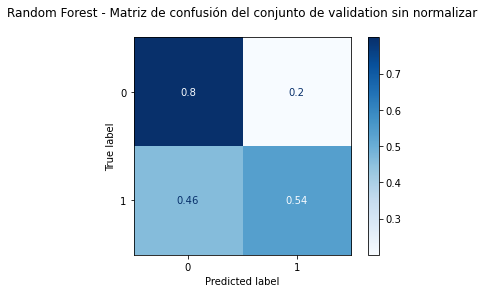

In [178]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## XGBoost - Grid Search

In [179]:
# Preproceso 1 para SGDRegressor - Default
scaler = MaxAbsScaler()
#ft_selector = LinearSVR(random_state=0)
model_ = XGBClassifier(random_state= 0, use_label_encoder=False)

In [180]:
param_grid = {
    'cla__alpha' : [0.01, 0.42, 0.30],
    'cla__max_depth': [8, 16, 32],
    'cla__n_estimators': [5, 10, 15],
    'cla__booster':['gbtree', 'dart'],
    'cla__eval_metric': ['mlogloss']
}

In [181]:
# Features and target
X = df.drop([ordinal_ft, target_c], axis=1)
y = df[target_c]

In [182]:
# Train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=False)

#### Preproceso y ajuste

In [183]:
# Preprocessing
num_transformer = scaler
cat_transformer = 'passthrough'

num_features = [g for g in X.columns if 'client' not in g]
cat_features = [g for g in X.columns if 'client' in g]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [184]:
# Fit
pipe = Pipeline([
  ('preprocessor', preprocessor),
#  ('feature_selection', SelectFromModel(ft_selector)),
  ('cla', model_)
])

model = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, verbose=1)

model.fit(X_train, y_train)
xgbc_cv = model

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [185]:
model.best_params_

{'cla__alpha': 0.42,
 'cla__booster': 'gbtree',
 'cla__eval_metric': 'mlogloss',
 'cla__max_depth': 8,
 'cla__n_estimators': 10}

In [186]:
# Predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#### Evaluacion de predicciones

In [187]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train, y_train_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de train
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      3402
           1       0.80      0.75      0.77      1808

    accuracy                           0.85      5210
   macro avg       0.84      0.83      0.83      5210
weighted avg       0.85      0.85      0.85      5210



In [188]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val, y_valid_pred))

RandomForestClassifier - Reporte de clasificación del conjunto de validacion
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1433
           1       0.60      0.54      0.57       800

    accuracy                           0.71      2233
   macro avg       0.68      0.67      0.67      2233
weighted avg       0.70      0.71      0.70      2233



Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

<Figure size 432x288 with 0 Axes>

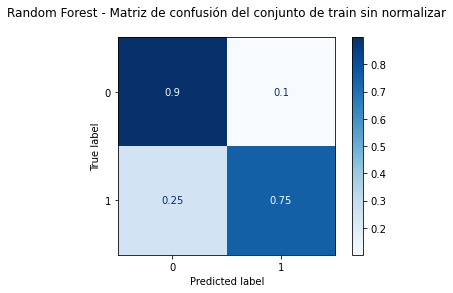

In [189]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de train sin normalizar\n')

Text(0.5, 1.0, 'Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

<Figure size 432x288 with 0 Axes>

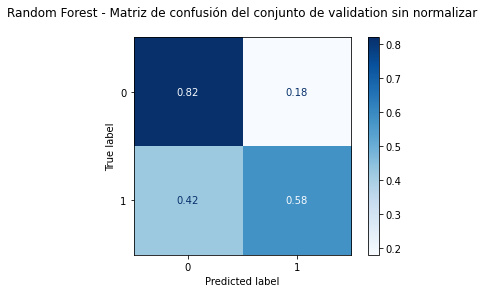

In [190]:
plt.figure()
plot_confusion_matrix(estimator= model, X=X_val, y_true=y_val,
                      normalize='true', cmap='Blues').ax_ \
                      .set_title('Random Forest - Matriz de confusión del conjunto de validation sin normalizar\n')

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [509]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.12.2


In [510]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

In [534]:
df_encode.columns

Index(['dni_titular_movimiento', 'anio_mes_cupon', 'edad_cliente',
       'antig_cliente', 'fecha_cupon_movimiento', 'trans__x0_AX',
       'trans__x0_EX', 'trans__x0_MC', 'trans__x0_PC', 'trans__x0_PL',
       'trans__x0_PN', 'trans__x0_PP', 'trans__x0_TA', 'trans__x0_VI',
       'trans__x0_ZE', 'trans__x1_0', 'trans__x1_22', 'trans__x1_3',
       'trans__x1_32', 'trans__x1_4', 'trans__x1_42', 'trans__x2_0',
       'trans__x2_1', 'trans__x2_3', 'trans__x3_0', 'trans__x3_1',
       'trans__x3_2', 'trans__x3_3', 'trans__x3_4', 'trans__x3_5',
       'trans__x3_6', 'trans__x3_7', 'trans__x3_8', 'trans__x3_9',
       'client__x0_Hombre', 'client__x0_Mujer', 'client__x0_Sin Datos',
       'client__x1_Sector_Educativo', 'client__x1_Sector_Empleado_Comercio',
       'client__x1_Sector_Financiero', 'client__x1_Sector_No_Operativo',
       'client__x1_Sector_Operativo', 'client__x1_Sector_Salud',
       'client__x1_Sector_Seguridad', 'client__x1_Sector_Sin_Datos',
       'client__x2_Casado', 'c

In [536]:
sf1 = df_encode[['fecha_cupon_movimiento', 'monto_ajustado', 'trans__x0_PL']]
sf2 = df_encode[['fecha_cupon_movimiento', 'monto_ajustado', 'trans__x0_VI']]

In [516]:
# Agrupa por fecha todos los montos para Plan Largo
cols = ['fecha_cupon_movimiento', 'monto']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [517]:
sf.reset_index(inplace=True)
sf

,fecha_cupon_movimiento,monto_compra_movimiento
0,2020-02-16,71760.00
1,2020-04-01,69055.20
2,2020-05-27,146558.07
3,2020-06-25,-22098.63
4,2020-07-01,-39054.00
...,...,...
289,2021-04-30,-235966.89
290,2021-05-02,-1653081.99
291,2021-05-06,3462.42
292,2021-05-10,90.39


In [518]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

2021-05-25
2020-02-16


In [519]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

,monto_compra_movimiento
fecha_cupon_movimiento,
2020-02-16,71760.00
2020-04-01,69055.20
2020-05-27,146558.07
2020-06-25,-22098.63
2020-07-01,-39054.00
...,...
2021-04-30,-235966.89
2021-05-02,-1653081.99
2021-05-06,3462.42


En series temporales se usa Series en lugar de Dataframe

In [520]:
ss = sf['monto_compra_movimiento']
ss

fecha_cupon_movimiento
2020-02-16      71760.00
2020-04-01      69055.20
2020-05-27     146558.07
2020-06-25     -22098.63
2020-07-01     -39054.00
                 ...    
2021-04-30    -235966.89
2021-05-02   -1653081.99
2021-05-06       3462.42
2021-05-10         90.39
2021-05-25     320269.71
Name: monto_compra_movimiento, Length: 294, dtype: float64

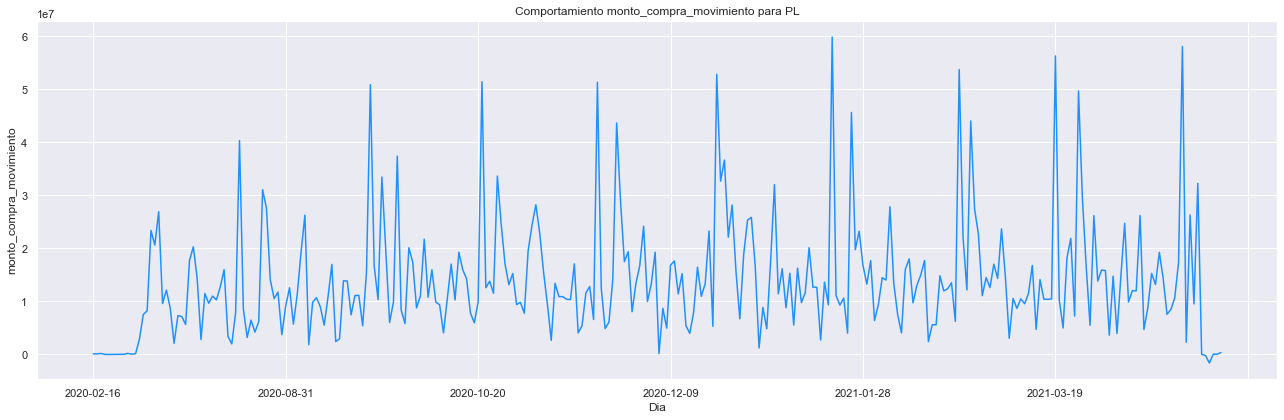

In [521]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [522]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [523]:
print(y_test.index.max())
print(y_test.index.min())

2021-05-25
2021-03-19


In [524]:
print(y_train.index.max())
print(y_train.index.min())

2021-03-18
2020-02-16


## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


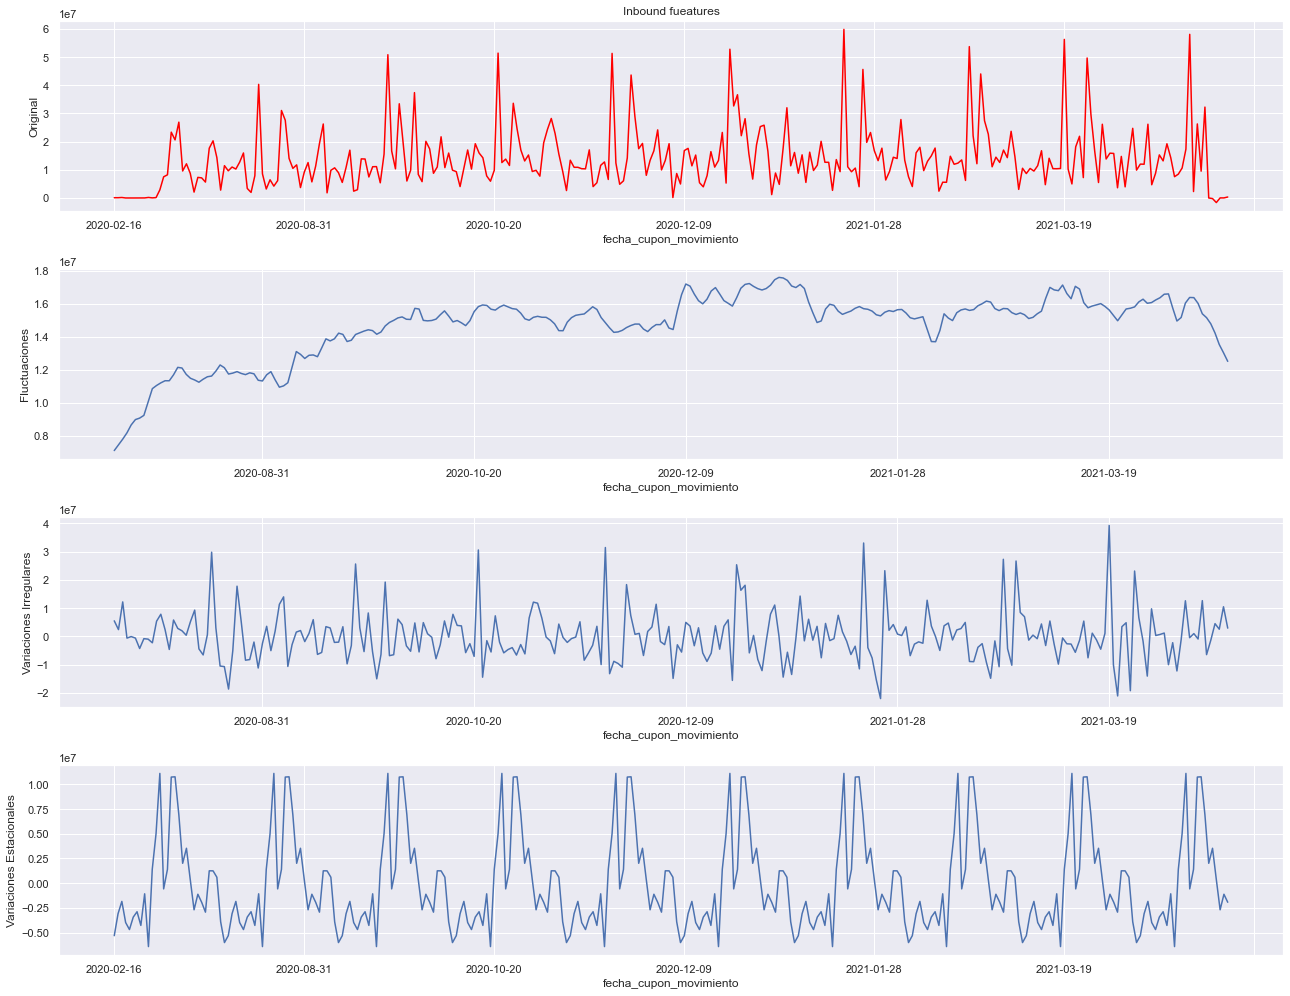

In [525]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [526]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

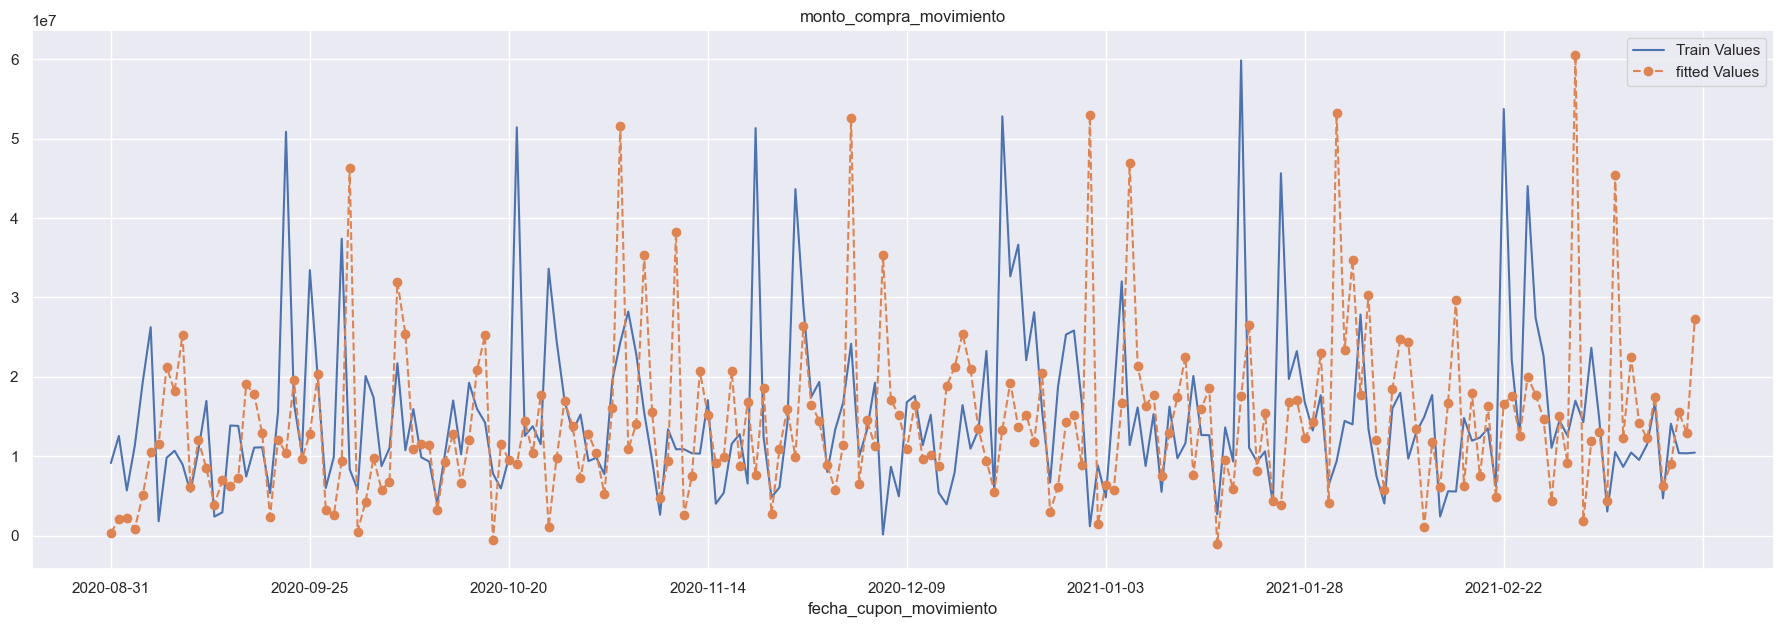

In [527]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [528]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

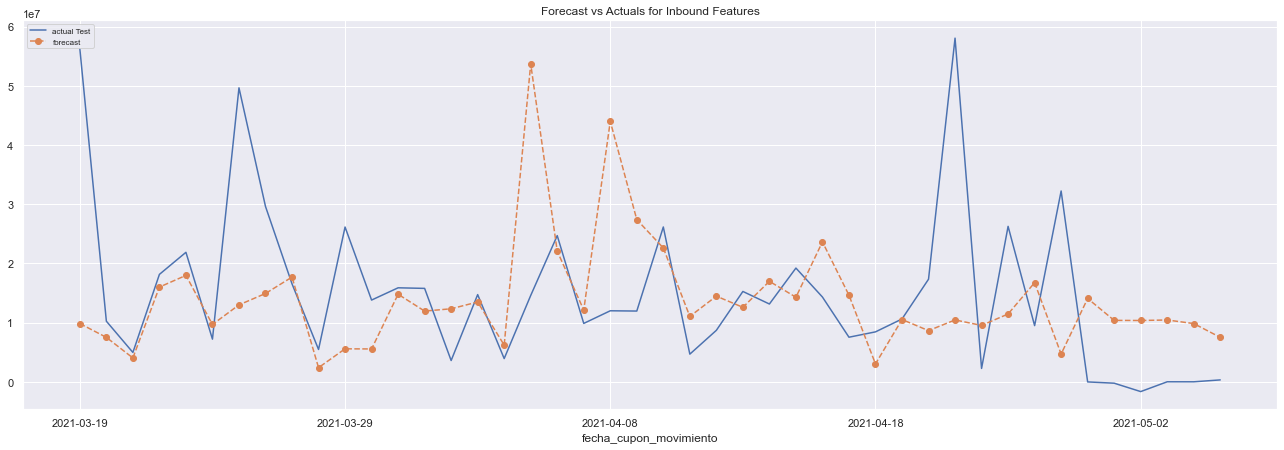

In [529]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [530]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

,RMSE,SE
0,1.623687e+07,2470284.646
